In [111]:
%load_ext autoreload
%autoreload 2

from darts.models import NHiTSModel
from darts import TimeSeries
from darts.utils.likelihood_models import QuantileRegression
import matplotlib.pyplot as plt
import utils
import pandas as pd
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
forecast_horizon = 36

In [113]:
# Papermill parameters

input_chunk_length = 18
n_epochs=10
batch_size=32
dropout=0.1
# add_encoders={'cyclic': {'future': ['month']}}
learning_rate=1e-4

num_stacks = 2 # Number of stacks that make up the whole model
num_blocks = 1 # Number of blocks per stack
num_layers = 1 # Number of layers per block
# layer_widths = 
# pooling_kernel_sizes = [(3), (3), (3)] # Kernel sizes for pooling layers
n_freq_downsample = ((), (), ()) # Tuple of tuples of size (num_stacks, num_blocks)
activation = "Sigmoid"

In [114]:
hparams = dict(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    # hidden_size = hidden_size,
    n_epochs=n_epochs,
    batch_size=batch_size,
    dropout=dropout,
    num_stacks=num_stacks,
    num_blocks=num_blocks,
    num_layers=num_layers,
    # layer_widths=layer_widths,
    # pooling_kernel_sizes=pooling_kernel_sizes,
    # n_freq_downsample=n_freq_downsample,
    activation=activation,
    optimizer_kwargs=dict(lr=learning_rate),
)

In [115]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# # Scale the time series and covariates
# covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True)
# covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False, should_scale=True, should_log=True)
# covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12, should_scale=True, should_log=True)
# pipeline, ts_scaled_full_hist = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)
# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled_full_hist = utils.scale_ts(ts, should_diff=True, diff_order=1)



# Ensure that all covariates are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_nodiff_scaled).slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_scaled).slice_intersect(covars_diff_yoy_scaled)
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)
ts_scaled = ts_scaled_full_hist.slice_intersect(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

/Users/Xavier/cdpq-ia/utils.py:225: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [116]:
from pytorch_lightning.callbacks import Callback


train_losses = []
val_losses = []

class LossAccumulatorCallback(Callback):
    """
    PyTorch Lightning Callback to accumulate training and validation losses per epoch.
    
    Attributes:
        train_losses (list): List to store training loss for each epoch.
        val_losses (list): List to store validation loss for each epoch.
    """
    
    def __init__(self):
        super().__init__()
    
    def on_train_epoch_end(self, trainer, pl_module):
        """
        Called when the train epoch ends.
        
        Args:
            trainer (pl.Trainer): The trainer instance.
            pl_module (pl.LightningModule): The model being trained.
        """
        # Retrieve the training loss from logged metrics
        # Assumes that 'train_loss' is the key used for logging training loss
        train_loss = trainer.callback_metrics.get('train_loss')
        
        if train_loss is not None:
            # Detach and move to CPU if necessary
            if isinstance(train_loss, torch.Tensor):
                train_loss = train_loss.detach().cpu().item()
            train_losses.append(train_loss)
            # print(f"Accumulated train_loss: {self.train_losses}")
        else:
            print("train_loss not found in callback_metrics.")
    
    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        
        if val_loss is not None:
            # Detach and move to CPU if necessary
            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.detach().cpu().item()
            val_losses.append(val_loss)
        else:
            print("train_loss not found in callback_metrics.")
    

    def on_train_end(self, trainer, pl_module):
        """
        Called when the training ends.
        
        Args:
            trainer (pl.Trainer): The trainer instance.
            pl_module (pl.LightningModule): The model that was trained.
        """
        pass

In [117]:
quantiles = [
    # 0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    # 0.99,
]


model = NHiTSModel(
    # log_tensorboard=True,
    # hidden_continuous_size=,
    # use_reversible_instance_norm=True,
    likelihood=QuantileRegression(quantiles=quantiles),  # QuantileRegression is set per default
    random_state=42,
    pl_trainer_kwargs={"callbacks": [LossAccumulatorCallback()]},
    **hparams
)

In [118]:
if False:
    lr_find_results = model.lr_find(
        series=train_ts_scaled, 
        past_covariates=train_covariates_scaled,
        val_series=val_ts_scaled,
        val_past_covariates = val_covariates_scaled, 
        verbose=True,
        min_lr=1e-30,
        early_stop_threshold=1000.0
    )
    # lr_find_results.plot(suggest=True, show=True)
    lr_find_results.suggestion()

In [119]:
lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
    }

unwanted_columns = [c for c in train_covariates_scaled.columns if c not in lags_past_covariates.keys()]
train_covariates_scaled = train_covariates_scaled.drop_columns(unwanted_columns)
covariates_scaled = covariates_scaled.drop_columns(unwanted_columns)
val_covariates_scaled = val_covariates_scaled.drop_columns(unwanted_columns)


In [120]:
model.fit(
        series=train_ts_scaled,
        past_covariates=train_covariates_scaled,
        val_series=val_ts_scaled,
        val_past_covariates = val_covariates_scaled, 
        verbose=True
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 2.8 M  | train
-------------------------------------------------------------
2.7 M     Trainable params
83.1 K    Non-trainable params
2.8 M     Total params
11.250    Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


NHiTSModel(output_chunk_shift=0, num_stacks=2, num_blocks=1, num_layers=1, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=Sigmoid, MaxPool1d=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), random_state=42, pl_trainer_kwargs={'callbacks': [<__main__.LossAccumulatorCallback object at 0x355aae8d0>]}, input_chunk_length=18, output_chunk_length=36, n_epochs=10, batch_size=32, optimizer_kwargs={'lr': 0.0001})

In [121]:
utils.plot_training_history(train_losses, val_losses)

In [122]:
import utils
forecasts_df = utils.make_forecasts(model, ts, ts_scaled_full_hist, covariates_scaled, pipeline)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
H

In [123]:
eval_metrics = utils.evaluate_by_horizon(forecasts_df)
eval_metrics

component,mean_abs_pct_error,mean_squared_error,mean_abs_error,root_mean_squared_error
horizon,,,,
1,7.193235,0.036764,0.143057,0.191740
2,12.048673,0.104535,0.237944,0.323318
3,16.365974,0.189753,0.318919,0.435607
4,20.427578,0.277435,0.394605,0.526721
5,23.758818,0.365307,0.460361,0.604406
6,27.396825,0.482572,0.533957,0.694674
7,31.035620,0.618832,0.614163,0.786659
8,34.319941,0.753061,0.687286,0.867791
9,36.961002,0.876327,0.745613,0.936123


In [124]:
utils.save_results(hparams, eval_metrics, "nhits_results.csv")

In [125]:
forecasts_df["horizon"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [126]:
forecasts_df = forecasts_df.rename(index={"DATE": 'Date'})
forecasts_ts = utils.get_ts_by_forecast_horizon(forecasts_df)

In [127]:
# before starting, we define some constants

figsize = (12, 4)
lowest_q, low_q, high_q, highest_q = 0.05, 0.1, 0.9, 0.95
label_q_outer = f"percentiles {int(lowest_q * 100)}-{int(highest_q * 100)}"
label_q_inner = f"percentiles {int(low_q * 100)}-{int(high_q * 100)}"

In [128]:
naive_forecasts = {}
for h in [1, 3, 12, 36]:
    naive_forecasts[h] = ts.shift(h).drop_before(pd.Timestamp("2016-01-01")).drop_after(pd.Timestamp("2023-09-01"))


for h, tss in forecasts_ts.items():
    forecasts_ts[h] = tss.drop_before(pd.Timestamp("2016-01-01"))

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_55140/4193098894.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_55140/4193098894.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_55140/4193098894.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_55140/4193098894.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



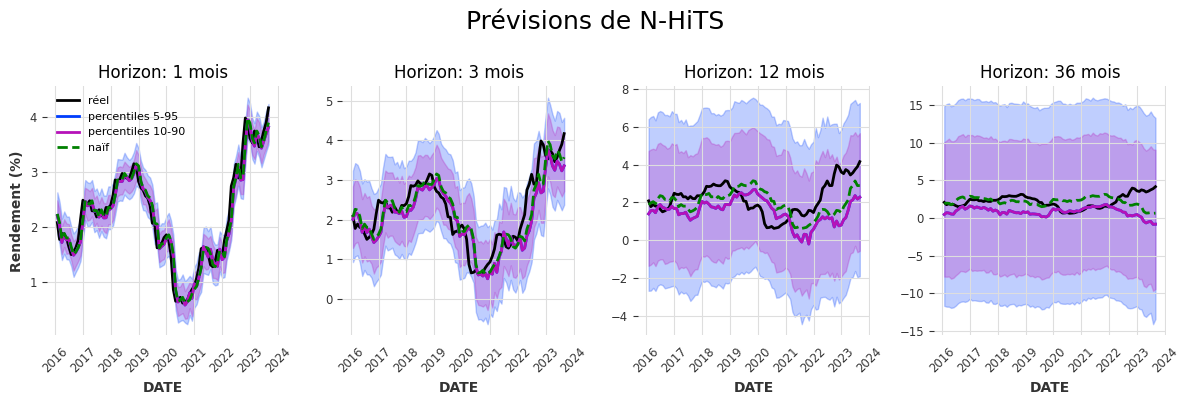

In [130]:

def plot_forecast_for_horizon(h, forecasts_ts, axs):
    fcast = forecasts_ts[h]
    
    # plot actual series
    ts[fcast.start_time(): ].plot(label="réel", ax=axs)
    
    # plot prediction with quantile ranges
    fcast.plot(
        low_quantile=0.1, high_quantile=0.95, label=label_q_outer, ax=axs
    )
    fcast.plot(low_quantile=0.3, high_quantile=0.7, label=label_q_inner, ax=axs) # 0.3 et 0.7 correspondent aux quantiles 0.05 et 0.95

    # plot naive forecast
    naive_forecasts[h].plot(label="naïf", ax=axs, color="green", linestyle="--")

    if axs.get_legend() and h != 1:
        axs.get_legend().remove()
    else:
        # Move the legend to the upper left corner and make is slightly smaller
        axs.legend(loc="upper left", fontsize=8)
    
    axs.set_title(f"Horizon: {h} mois", fontsize=12)
    if h == 1:
        axs.set_ylabel("Rendement (%)")
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45)

fig, axs = plt.subplots(1, 4, sharex="col", sharey=False, figsize=figsize)
fig.suptitle("Prévisions de N-HiTS", fontsize=18, y=1.0)

for i, h in enumerate((1, 3, 12, 36)):
    plot_forecast_for_horizon(h, forecasts_ts, axs[i])

plt.tight_layout()
plt.savefig("nhits_plot.png")


# Performance Test Set

In [131]:
import utils

# Load data
df = utils.load_data(test=True)

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# # Scale the time series and covariates
# covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True)
# covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False, should_scale=True, should_log=True)
# covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12, should_scale=True, should_log=True)
# pipeline, ts_scaled_full_hist = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)
# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled_full_hist = utils.scale_ts(ts, should_diff=True, diff_order=1)



# Ensure that all covariates are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_nodiff_scaled).slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_scaled).slice_intersect(covars_diff_yoy_scaled)
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)
ts_scaled = ts_scaled_full_hist.slice_intersect(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)


lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
    }

unwanted_columns = [c for c in train_covariates_scaled.columns if c not in lags_past_covariates.keys()]
train_covariates_scaled = train_covariates_scaled.drop_columns(unwanted_columns)
covariates_scaled = covariates_scaled.drop_columns(unwanted_columns)
val_covariates_scaled = val_covariates_scaled.drop_columns(unwanted_columns)


/Users/Xavier/cdpq-ia/utils.py:225: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [179]:
import utils
future_fore = utils.make_forecasts(model, ts, ts_scaled_full_hist, covariates_scaled, pipeline)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Xavier/cdpq-ia/utils.py:69: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Xavier/cdpq-ia/utils.py:69: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 

In [180]:
future_fore = future_fore.rename(index={"DATE": 'Date'})
forecasts_ts = utils.get_ts_by_forecast_horizon(future_fore)

In [194]:
future_fore

component,US_TB_YIELD_10YRS,lowest_q,low_q,forecast,high_q,highest_q,error,forecast_date,horizon
2024-08-31,3.869,3.836704,3.861533,4.164286,4.526957,4.628660,-0.295286,2024-07-31,1
2024-09-30,NaN,3.370108,3.525086,4.091411,4.808667,4.941196,NaN,2024-07-31,2
2024-10-31,NaN,2.939166,3.156012,4.080181,5.083815,5.319878,NaN,2024-07-31,3
2024-11-30,NaN,2.545201,2.843647,4.071590,5.378541,5.824032,NaN,2024-07-31,4
2024-12-31,NaN,2.116147,2.457803,3.990801,5.659416,6.145379,NaN,2024-07-31,5
2025-01-31,NaN,1.735470,2.124225,3.981946,5.972972,6.517961,NaN,2024-07-31,6
2025-02-28,NaN,1.271742,1.759165,3.901057,6.227183,6.900815,NaN,2024-07-31,7
2025-03-31,NaN,0.875200,1.476147,3.852867,6.554940,7.354456,NaN,2024-07-31,8
2025-04-30,NaN,0.478312,1.146821,3.784993,6.894277,7.724957,NaN,2024-07-31,9
2025-05-31,NaN,0.068994,0.790168,3.740535,7.252754,8.096934,NaN,2024-07-31,10


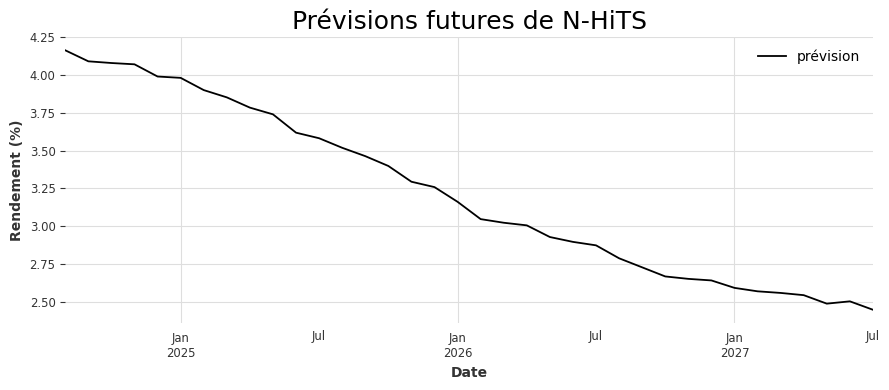

In [212]:
future_fore = future_fore[future_fore["forecast_date"] == "2024-07-31"]

# Plot forecast with intervals using DataFrame, not TimeSeries
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
future_fore["forecast"].plot(label="prévision", ax=ax, color="black")
# ax.fill_between(future_fore.index, future_fore["low_q"], future_fore["high_q"], color="purple", alpha=0.3)
# ax.fill_between(future_fore.index, future_fore["lowest_q"], future_fore["highest_q"], color="blue", alpha=0.2)
ax.set_title("Prévisions futures de N-HiTS", fontsize=18)
ax.legend()
ax.set_ylabel("Rendement (%)")
ax.set_xlabel("Date")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, sharex="col", sharey=False, figsize=figsize)
fig.suptitle("Prévisions de N-HiTS", fontsize=18, y=1.0)

for i, h in enumerate((1, 3, 12, 36)):
    plot_forecast_for_horizon(h, forecasts_ts, axs[i])

plt.tight_layout()
plt.savefig("nhits_plot.png")

<Axes: xlabel='DATE'>

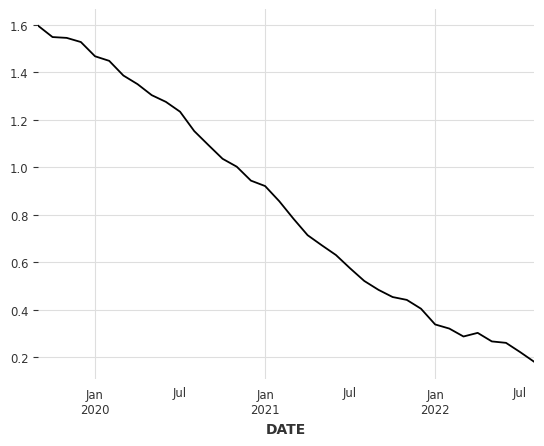

In [169]:
future_fore[-60].plot()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

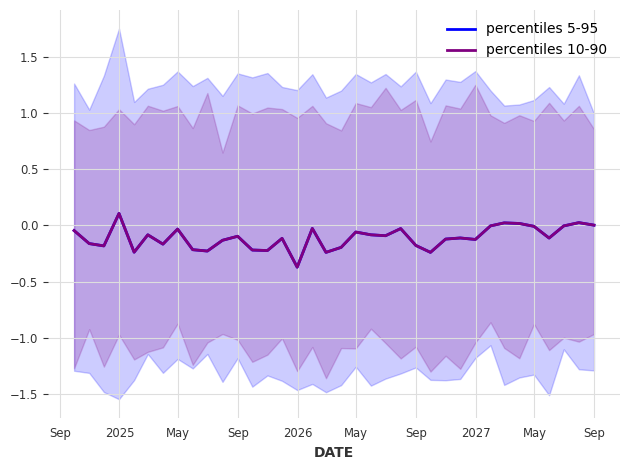

In [166]:
preds = model.predict(series=ts_scaled, past_covariates=covariates_scaled, num_samples=300, n=36)

# preds.plot(color="black", label="Prédictions")
preds.plot(low_quantile=0.05, high_quantile=0.95, label=label_q_outer, color="blue", alpha=0.2)
preds.plot(low_quantile=0.1, high_quantile=0.9, label=label_q_inner, color="purple", alpha=0.2)

plt.tight_layout()
